In [2]:
import pandas as pd
import numpy as np

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import webbrowser

### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

### 화재 예측 범위 계산

In [3]:
# 1. Shapefile 불러오기
gdf_archive = gpd.read_file("./USA data/shapefile/fire_archive_SV-C2_590697.shp")
gdf_nrt = gpd.read_file("./USA data/shapefile/fire_nrt_SV-C2_590697.shp")
gdf = pd.concat([gdf_archive, gdf_nrt], ignore_index=True)
gdf = gdf.to_crs(epsg=4326)

# 2. cleaned_wildfire_df 불러오기
cleaned_wildfire_df = pd.read_csv("./USA data/cleaned_wildfire.csv")
cleaned_wildfire_df['acq_date'] = pd.to_datetime(cleaned_wildfire_df[['year', 'month', 'day']])

# 3. GeoDataFrame 변환
geometry = [Point(lon, lat) for lon, lat in zip(cleaned_wildfire_df['longitude'], cleaned_wildfire_df['latitude'])]
geo_df = gpd.GeoDataFrame(cleaned_wildfire_df, geometry=geometry, crs="EPSG:4326")

# 4. 동적 버퍼 및 면적 계산
gdf = gdf.to_crs(epsg=32610)
gdf['buffer_radius'] = gdf['FRP'].apply(lambda x: min(500 + x * 10, 2000))  # FRP 비례 버퍼
gdf['geometry'] = [geom.buffer(radius) for geom, radius in zip(gdf['geometry'], gdf['buffer_radius'])]
gdf['predicted_area_km2'] = gdf.geometry.area / 1e6

# 5. 병합 데이터 준비 (burned_area_km2 제외)
shapefile_df = gdf[['LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'predicted_area_km2']]
shapefile_df['ACQ_DATE'] = pd.to_datetime(shapefile_df['ACQ_DATE'])
shapefile_df.columns = ['latitude', 'longitude', 'acq_date', 'predicted_area_km2']

# 6. 병합
merged_df = geo_df.merge(shapefile_df, on=['latitude', 'longitude', 'acq_date'], how='outer')
merged_df['predicted_area_km2'] = merged_df['predicted_area_km2'].fillna(0)

# 7. 결과 저장 및 확인
merged_df.to_csv("./USA data/merged_fire.csv", index=False)
print(merged_df["predicted_area_km2"].describe())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12220\1253976144.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shapefile_df['ACQ_DATE'] = pd.to_datetime(shapefile_df['ACQ_DATE'])


count    906078.000000
mean          1.552139
std           1.982098
min           0.784137
25%           0.842261
50%           0.930437
75%           1.233068
max          12.546194
Name: predicted_area_km2, dtype: float64


In [4]:
wildfire_eda = pd.read_csv("./USA data/merged_fire.csv")
wildfire_eda.info()

# 결측치 확인
print("결측치 개수 (처리 전):\n", wildfire_eda.isnull().sum())

# 결측치 처리 (결측치가 없더라도 명시적으로 처리)
# 현재는 결측치가 없으므로 이 단계는 스킵되지만, 코드에 포함시켜 안정성 확보
wildfire_eda = wildfire_eda.dropna()

# 데이터 타입 & 구조 확인
print("데이터 타입:\n", wildfire_eda.dtypes)

# 결측치 확인 (처리 후)
print("결측치 개수 (처리 후):\n", wildfire_eda.isnull().sum())

# 7. 결과 저장 및 확인
wildfire_eda.to_csv("./USA data/merged_fire.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906078 entries, 0 to 906077
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               906078 non-null  float64
 1   longitude              906078 non-null  float64
 2   brightness             900596 non-null  float64
 3   bright_t31             900596 non-null  float64
 4   frp                    900596 non-null  float64
 5   T2M                    900596 non-null  float64
 6   WS2M                   900596 non-null  float64
 7   RH2M                   900596 non-null  float64
 8   PRECTOTCORR            900596 non-null  float64
 9   confidence_h           900596 non-null  float64
 10  confidence_l           900596 non-null  float64
 11  confidence_n           900596 non-null  float64
 12  daynight_D             900596 non-null  float64
 13  daynight_N             900596 non-null  float64
 14  year                   900596 non-nu

### 시각화

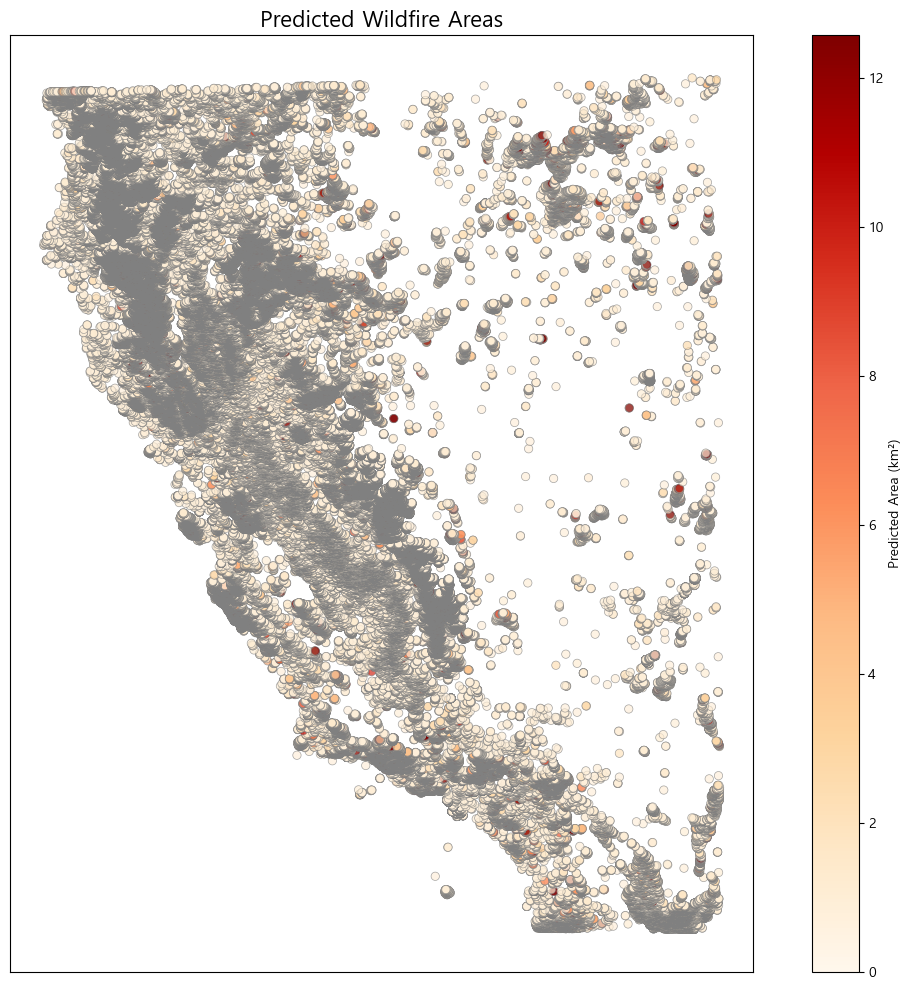

In [23]:
# 1. merged_fire.csv 로드 및 GeoDataFrame 변환
merged_df = pd.read_csv("./USA data/merged_fire.csv")
# geometry를 Point 객체로 변환
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")

# 2. 데이터 보정 (ValueError 방지)
# frp 값 보정: NaN 또는 inf를 0으로 대체
merged_gdf['frp'] = merged_gdf['frp'].replace([np.inf, -np.inf], np.nan).fillna(0)
# acq_date 처리
if 'acq_date' not in merged_gdf.columns:
    print("Warning: 'acq_date' not found, using placeholder")
    merged_gdf['acq_date'] = "Unknown"
else:
    merged_gdf['acq_date'] = pd.to_datetime(merged_gdf['acq_date'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

# 3. GeoPandas로 기본 지도 시각화 (검은색 테두리 조정)
fig, ax = plt.subplots(figsize=(12, 10))
merged_gdf.plot(
    ax=ax,
    column='predicted_area_km2',
    cmap='OrRd',
    edgecolor='gray',           # 검은색 대신 회색
    linewidth=0.5,              # 테두리 두께 줄임
    alpha=0.7,
    legend=True,
    vmin=0,
    vmax=12.566,
    legend_kwds={'label': "Predicted Area (km²)", 'orientation': "vertical"}
)
ax.set_title("Predicted Wildfire Areas", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [24]:
# 4. Folium으로 인터랙티브 지도 시각화 (당신의 HTML 스타일 유지)
# 샘플링 (10% 사용)
merged_gdf_sample = merged_gdf.sample(frac=0.1, random_state=42)

# 지도 생성 (당신의 스타일: 기본 타일, 캘리포니아 중심)
m = folium.Map(location=[37.5, -120], zoom_start=6)  # 기본 타일 사용
marker_cluster = MarkerCluster().add_to(m)

# GeoJSON 변환 및 팝업 설정
geojson_data = merged_gdf_sample.to_json()
folium.GeoJson(
    geojson_data,
    name="Fire Detection",
    style_function=lambda x: {
        'fillColor': 'red',        # 빨간색 채우기 유지
        'color': 'gray',           # 검은색 대신 회색으로 변경
        'weight': 0.5,             # 테두리 두께 줄여 시각성 개선
        'fillOpacity': 0.6         # 약간 투명하게
    },
    popup=folium.features.GeoJsonPopup(
        fields=['predicted_area_km2', 'acq_date', 'frp'],
        aliases=['Predicted Area (km²)', 'Date', 'FRP'],
        localize=True,
        labels=True
    )
).add_to(marker_cluster)

# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser
